<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/epat/dmp_ass_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance # as I use google colab

     |████████████████████████████████| 6.3 MB 13.1 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.64-py2.py3-none-any.whl size=24109 sha256=24ce71e4a569a2f2329a469c427375aae0d8a46389f56591ee9d3ac7a65da6b2
  Stored in directory: /root/.cache/pip/wheels/86/fe/9b/a4d3d78796b699e37065e5b6c27b75cff448ddb8b24943c288
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


####Q1: Try out the ‘Big Moves Monday’ strategy on the above data with the standard conditions as taught in the class. Now back-test the strategy again but this time tweak one of the conditions such that the ‘ibs’ value must be lower than 0.8. Compare the results(total return) with the standard conditions case. Comment on the results. (5 marks)

In [ ]:
#import packages
import yfinance as yf  # yahoo finance api
import numpy as np # scientifc calc package
import pandas as pd # dataframe manipulation package
import matplotlib.pyplot as plt # for plotting purpose
import datetime as datetime

In [ ]:
def download_daily_data(ticker, start, end):
    """ 
    The function downloads daily market data to a pandas DataFrame 
    using the 'yfinance' API between the dates specified.
    """
    data = yf.download(ticker, start, end)

    return data

def compute_daily_returns(data):
    """ 
    Fucntion computes ---> 1 day log returns and store it in variable cc_returns'.
    """
    data['cc_returns'] = np.log(data['Close'] / data['Close'].shift(1))

    return data

ticker2 = "MSFT"
START = datetime.date(2015,1,2)
END = datetime.date(2020,4,30)

df = download_daily_data(ticker=ticker2, start=START, end=END)
df.head()
df.tail()

df2 = df.copy()
df2 = compute_daily_returns(data=df2)


[*********************100%***********************]  1 of 1 completed


In [ ]:

def compute_indicators(data):
    """
    Creates Additional Day column for "Big Move Monday Strategy"
    """
    # Columns created to check condition 1 : close today wrt four days after
    data['day'] = data.index.day_name()
    data['prev_day'] = data['day'].shift(1)
    data['four_days_after'] = data['day'].shift(-4)

    # Columns created to check condition 2 : 25 sma of relative range of the day.
    data['relative_range'] = (data['High'] - data['Low']) / data['Close']
    data['rel_range_ma'] = data['relative_range'].rolling(window=25).mean()

    # Column created to check condition 3
    data['ibs'] = (data['Close'] - data['Low']) / (data['High'] - data['Low'])

    return data

In [ ]:
def backtest_strategy(data):
    """
    The function creates additional columns to the pandas DataFrame for checking conditions
    to backtest the "Big Moves on Mondays" trading strategy. 
    It then computes the strategy returns.
    IMPORTANT: To be run ONLY after the function compute_indicators.
    """
    # make condition one binary 1 or 0
    data['condition1'] = np.where((data['day'] == 'Monday') 
                            & (data['prev_day'] == 'Friday') 
                            & (data['four_days_after'] == 'Friday'), 
                            1, 0)
    # make condition two binary 1 or 0
    data['condition2'] = np.where((1 - data['Close'] / data['Close'].shift(1))
                                  >= 0.25 * data['rel_range_ma'], 1, 0)
    # make condition three binary 1 or 0
    data['condition3'] = np.where(data['ibs'] < 0.8, 1, 0)
    
    # make condition four binary 1 or 0
    data['signal'] = np.where((data['condition1']==1) 
                        & (data['condition2']==1) 
                        & (data['condition3']==1), 
                        1, 0)

    # The below two statements ensures that we can directly calculate strategy returns by multiplying the 
    # columns 'position' and 'cc_returns'
    data['signal'] = data['signal'].shift(1)

    data['position'] = data['signal'].replace(to_replace=0, method='ffill', limit=3)

    data['strategy_returns'] = data['cc_returns'] * data['position']

    return data


In [ ]:
def show_backtesting_results(data):
    """
    The function displays the cumulative returns from the trading strategy and a buy-and-hold strategy. 
    It also plots a chart showing both returns and position over time.
    IMPORTANT: To be run ONLY after the function backtest_strategy.
    """
    print('Buy and hold returns: ', np.round(data['cc_returns'].cumsum()[-1], 2))
    print('Strategy returns: ', np.round(data['strategy_returns'].cumsum()[-1], 2))

    data[['cc_returns', 'strategy_returns']] = data[['cc_returns', 'strategy_returns']].cumsum()
    data[['cc_returns', 'strategy_returns', 'position']].plot(
        secondary_y='position', grid=True, figsize=(12, 8))


df = download_daily_data(ticker2, START, END)
df2 = df.copy()

[*********************100%***********************]  1 of 1 completed


Buy and hold returns:  1.33
Strategy returns:  0.66


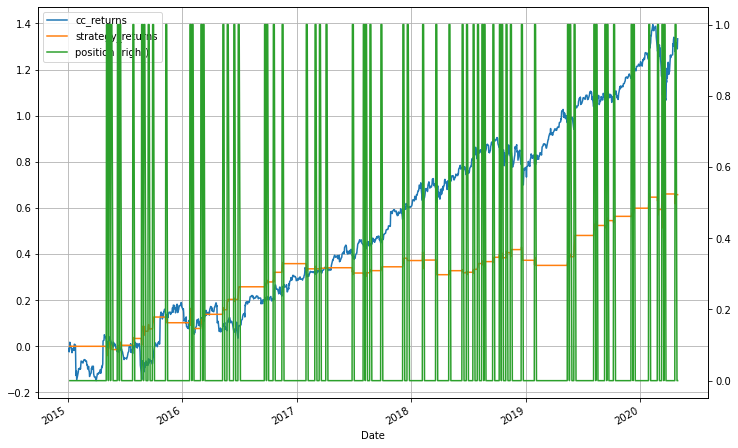

In [ ]:
df2 = compute_daily_returns(df2)
df2 = compute_indicators(df2)
df2 = backtest_strategy(df2)
show_backtesting_results(df2)

Comments : This Strategy under performs the simple buy and hold stocks strategy by a huge margin of 50%.

####Q2: You have seen a strategy based on MACD indicator in the class. Now back-test the following strategy based on Bollinger bands:
(i)      Create 20-day (+/- 2 standard deviations) Bollinger bands on the adjusted close price for the above equity
(ii)     Buy when the price crosses the lower band from top and hold until the price crosses the upper band from below the next time.
(iii)     Sell when the price crosses the upper band from below and hold until the price crosses the lower band from top the next time.
(iv)    Once we get into a trade, we always have an open position at all times.
Compare the total returns of the above strategy with a simple ‘buy & hold’ strategy. Comment on your findings. (5 Marks)


In [ ]:
def create_bollinger_bands(df):
    ''' Create a bollinger band for the given parameters'''
    # Calculate 20 Day Moving Average, Std Deviation, Upper Band and Lower Band
    df['20 Day MA'] = df['Adj Close'].rolling(window=20).mean()

    # set .std(ddof=0) for population std instead of sample
    df['20 Day STD'] = df['Adj Close'].rolling(window=20).std() 


    # set .std(ddof=0) for population std instead of sample
    df['Upper Band'] = df['20 Day MA'] + (df['20 Day STD'] *2)
    df['Lower Band'] = df['20 Day MA'] - (df['20 Day STD'] *2)
    return df

def plot_bollinger_band(df):
    # Simple 30 Day Bollinger Band plot
    df[['Close','20 Day MA','Upper Band', 'Lower Band']][-100:].plot(figsize=(17,6),linewidth=1)
    plt.title('20 Day Bollinger Band with 2 standard deviation')
    plt.ylabel('0--100')
    plt.show();

In [ ]:
df3=df.copy()

In [ ]:
df3=create_bollinger_bands(df3)

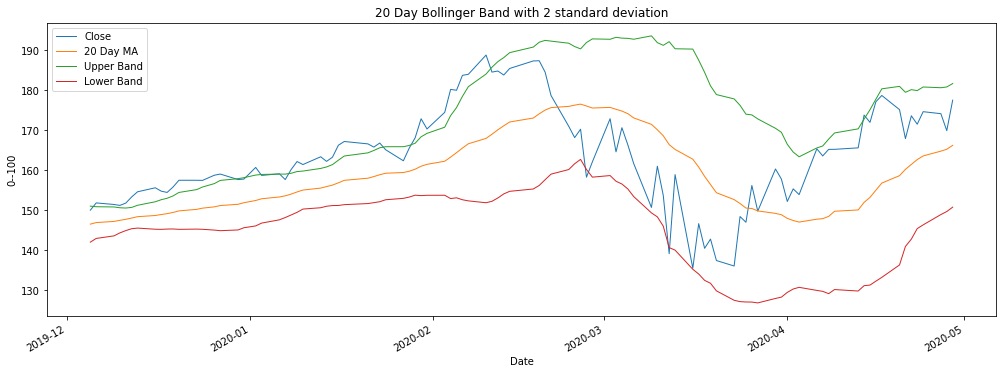

In [ ]:
plot_bollinger_band(df3)

In [ ]:
df3['position_long'] = np.where(df3['Close'] < df3['Lower Band'], 1, 0)
df3['position_short'] = np.where(df3['Close'] > df3['Upper Band'], 1, 0)
df3['position'] = (df3['position_short']+df3['position_long']).shift(1)

df3['cc_returns'] = df3['Close'].pct_change()
df3['strategy_returns'] = df3['cc_returns'] * df3['position']

df3['cumulative_returns'] = (1 + df3['strategy_returns']).cumprod() - 1

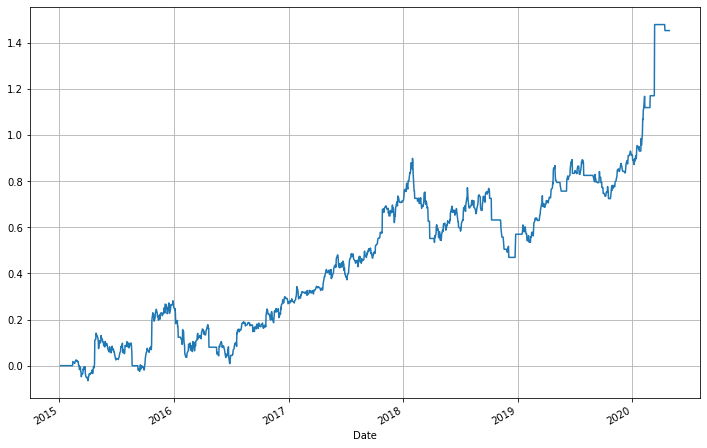

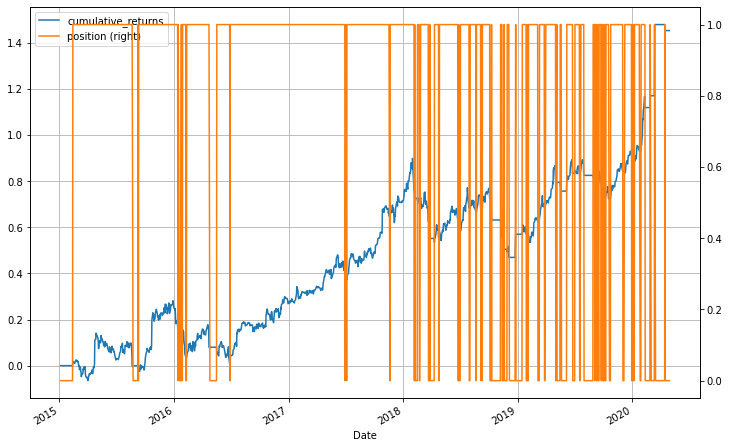

In [ ]:
df3['cumulative_returns'].plot(figsize=(12, 8), grid=True)

df3[['cumulative_returns', 'position']].plot(figsize=(12, 8), secondary_y='position', grid=True)

In [ ]:
def backtest_strategy(data):
    """
    The function creates additional columns to the pandas DataFrame for checking conditions
    to backtest the "Big Moves on Mondays" trading strategy. 
    It then computes the strategy returns.
    IMPORTANT: To be run ONLY after the function compute_indicators.
    """
    data['strategy_returns'] = data['cc_returns'] * data['position']

    return data

Buy and hold returns:  1.54
Strategy returns:  1.0


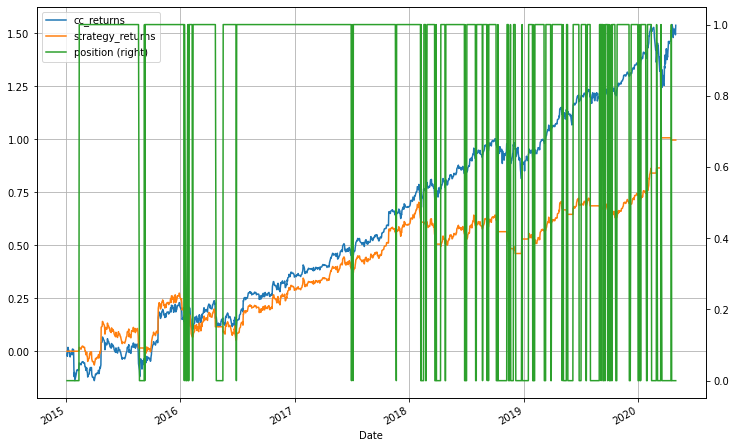

In [ ]:
df3 = backtest_strategy(df3)
show_backtesting_results(df3)

Buy and Hold Does Better than the strategy.

####Q5: Download the data for the following companies TSLA, NFLX, AMZN, GOOG and CVX using the code for automatically downloading multiple stocks from January 1st 2015 to April 30th 2020.  You can use Yahoo Finance for downloading the data. (5 Marks)
For the above-mentioned time period
a) Compute the daily returns (assuming you buy at open and sell at close) every day.
b) Compute the hit ratio for each of them(recall that the hit ratio is the ratio of number of positive trades to total number of trades).
c) Compute the cumulative returns for each of them.
Plot them graphically and comment on your results.


In [ ]:
from concurrent import futures

In [ ]:
def download_stocks(stock):
    try:
        START = datetime.datetime(2015,1,15)
        END = datetime.datetime(2020,4,20)
        print('Trying to retrieve the %s symbol...\n' % (stock))
        stock_df = yf.download(stock, start=START, end=END)
        stock_df['Name'] = stock
        output_name = stock + '.csv'
        list_stocks.append(output_name)
        stock_df.to_csv(output_name)
        print('Symbol %s downloaded OK.\n' % (stock))
    except:
        bad_tickers.append(stock)
        print('Problems downloading the %s symbol.\n' % (stock))

stocksList = ['TSLA', 'AMZN','NFLX', 'CVX', 'GOOG' ]
list_stocks = []

### Keeping track of failed ticker download queries
bad_tickers = []



# We use the concurrent.futures module's ThreadPoolExecutor 
# to speed up the downloads by doing them in parallel rather than serially

### Set the maximum thread number
max_workers = 50

workers = min(max_workers, len(stocksList)) 
### In case a smaller number of stocks than threads was passed in
with futures.ThreadPoolExecutor(workers) as executor:
    res = executor.map(download_stocks, stocksList)
### map allows multiple calls to the given function. It passes each of the items in stocksList (any 
### iterable) to the function. Here, it can happen concurrently because of the ThreadPoolExecutor()
### subClass

Trying to retrieve the TSLA symbol...

Trying to retrieve the AMZN symbol...

Trying to retrieve the NFLX symbol...

Trying to retrieve the CVX symbol...

Trying to retrieve the GOOG symbol...

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Problems downloading the CVX symbol.


Problems downloading the NFLX symbol.


Problems downloading the TSLA symbol.


Problems downloading the GOOG symbol.

Symbol AMZN downloaded OK.



The WebReader is having trouble downloading data , so we can download the above using simple list comprehension as below

In [ ]:
def download_stocks(stock):
    try:
        START = datetime.datetime(2015,1,15)
        END = datetime.datetime(2020,4,20)
        print('Trying to retrieve the %s symbol...\n' % (stock))
        stock_df = yf.download(stock,start=START, end=END)
        stock_df['Name'] = stock
        output_name = stock + '.csv'
        list_stocks.append(output_name)
        stock_df.to_csv(output_name)
        print('Symbol %s downloaded OK.\n' % (stock))
    except:
        bad_tickers.append(stock)
        print('Problems downloading the %s symbol.\n' % (stock))

stocksList = ['TSLA', 'AMZN','NFLX', 'CVX', 'GOOG' ]
list_stocks = []

### Keeping track of failed ticker download queries
bad_tickers = []

for item in stocksList:
  download_stocks(item)

Trying to retrieve the TSLA symbol...

[*********************100%***********************]  1 of 1 completed
Symbol TSLA downloaded OK.

Trying to retrieve the AMZN symbol...

[*********************100%***********************]  1 of 1 completed
Symbol AMZN downloaded OK.

Trying to retrieve the NFLX symbol...

[*********************100%***********************]  1 of 1 completed
Symbol NFLX downloaded OK.

Trying to retrieve the CVX symbol...

[*********************100%***********************]  1 of 1 completed
Symbol CVX downloaded OK.

Trying to retrieve the GOOG symbol...

[*********************100%***********************]  1 of 1 completed
Symbol GOOG downloaded OK.



In [ ]:
# calculate the daily return
def daily_returns(df):
  '''Calculate the daily returns from open to close'''
  df['daily_returns']=(df['Close']-df['Open'])/df['Close']
  return df
def cal_hit_ratio(df):
  ''' No. of positive trades vs total trade'''
  df['count_hit']=np.sign(df['daily_returns']) 
  df['hit']=np.where(df['count_hit']>0,1,0)
  var=round(df['hit'].sum()/len(df)*100)
  print(f'Hit ratio is : {var} %')

In [ ]:
tsla =pd.read_csv('/content/TSLA.csv')

In [ ]:
tsla=daily_returns(tsla)

In [ ]:
cal_hit_ratio(tsla)

Hit ratio is : 51 %


In [ ]:
print('Strategy returns: ',(tsla['daily_returns']+1).cumprod().iloc[-1]-1)

Strategy returns:  -0.17542279447756426


In [ ]:
amzn =pd.read_csv('/content/AMZN.csv')
amzn=daily_returns(amzn)
cal_hit_ratio(amzn)
print('Strategy returns: ',(amzn['daily_returns']+1).cumprod().iloc[-1]-1)

Hit ratio is : 50 %
Strategy returns:  -0.16934015853212037


In [ ]:
cvx =pd.read_csv('/content/CVX.csv')
cvx=daily_returns(cvx)
cal_hit_ratio(cvx)
print('Strategy returns: ',(cvx['daily_returns']+1).cumprod().iloc[-1]-1)

Hit ratio is : 48 %
Strategy returns:  -0.30833658758409455


In [ ]:
goog =pd.read_csv('/content/GOOG.csv')
goog=daily_returns(goog)
cal_hit_ratio(goog)
print('Strategy returns: ',(goog['daily_returns']+1).cumprod().iloc[-1]-1)

Hit ratio is : 52 %
Strategy returns:  0.43068624961865365


In [ ]:
nflx =pd.read_csv('/content/NFLX.csv')
nflx=daily_returns(nflx)
cal_hit_ratio(nflx)
print('Strategy returns: ',(nflx['daily_returns']+1).cumprod().iloc[-1]-1)

Hit ratio is : 49 %
Strategy returns:  0.1935342757117724


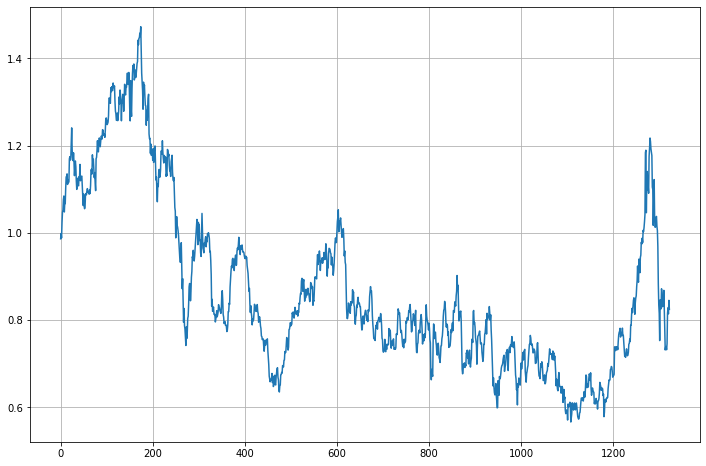

In [ ]:
(tsla['daily_returns']+1).cumprod().plot(figsize=(12, 8), grid=True);
plt.title('Tesla')
plt.show()

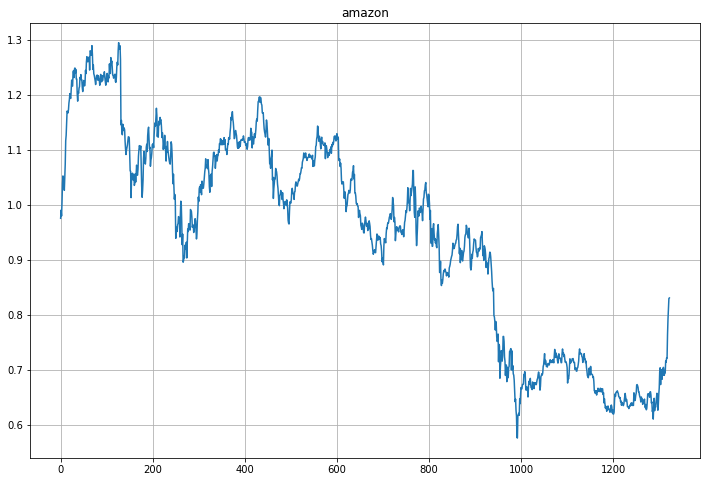

In [ ]:
(amzn['daily_returns']+1).cumprod().plot(figsize=(12, 8), grid=True);
plt.title('amazon')
plt.show()

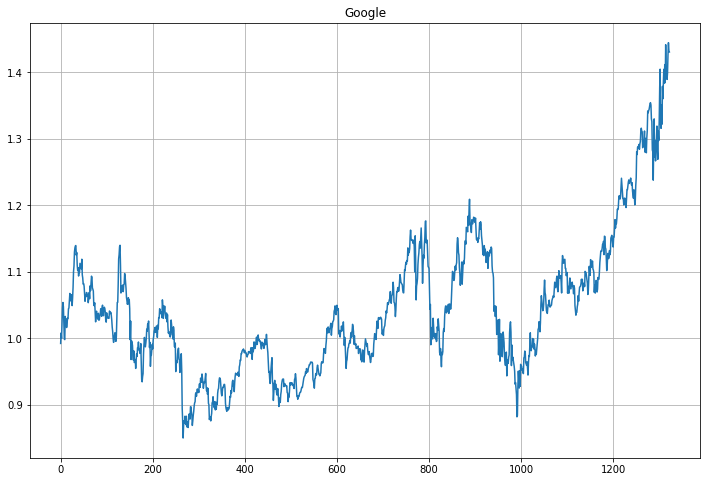

In [ ]:
(goog['daily_returns']+1).cumprod().plot(figsize=(12, 8), grid=True);
plt.title('Google')
plt.show()

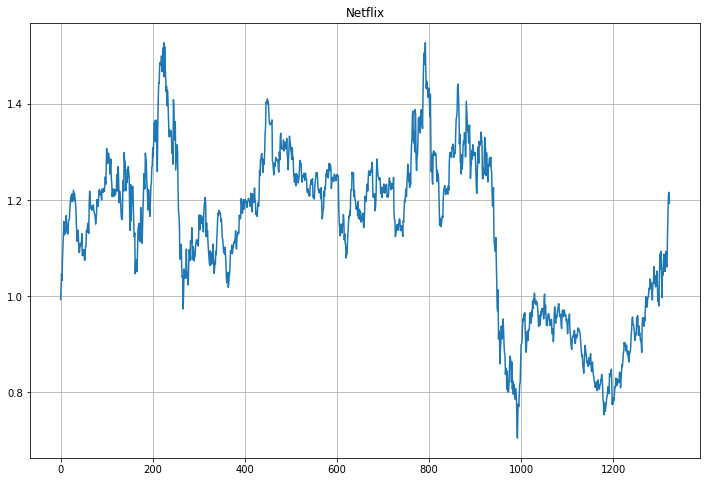

In [ ]:
(nflx['daily_returns']+1).cumprod().plot(figsize=(12, 8), grid=True);
plt.title('Netflix')
plt.show()

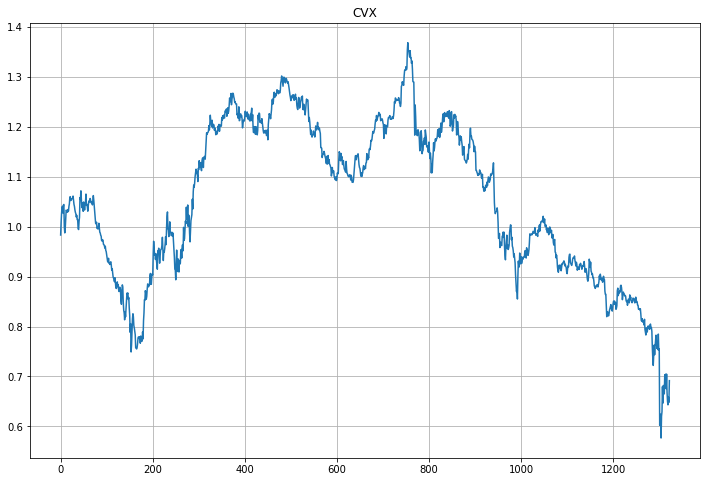

In [ ]:
(cvx['daily_returns']+1).cumprod().plot(figsize=(12, 8), grid=True);
plt.title('CVX')
plt.show()

####Q3: Write a customized function that computes returns for the exponential moving average (EMA) strategy (discussed in class) for different windows(spans). Find the optimal value of span between 1 and 30 which produces the best overall total return. (5 Marks)

In [77]:
def optimum_ema(df_orig,period):
  list_of_ema=[]
  for i in range(1,period+1,1):
    df=df_orig.copy()
    df['cc_returns'] = df['Close'].pct_change()
    ema = i
    df['ema'] = df['Adj Close'].ewm(span=ema, adjust=False).mean()
  
    df['position'] = np.where((df['Adj Close'] > df['ema']), 1, 0)
    df['position'] = df['position'].shift(1)

    

    df['strategy_returns'] = df['cc_returns'] * df['position']


    df['strategy_returns'] = 1 + df['strategy_returns']
    df['cc_returns'] = 1 + df['cc_returns']
    #print(i)
    list_of_ema.append([i,np.round(df['strategy_returns'].cumprod()[-1], 2)])

    #df1b[['cc_returns', 'strategy_returns']].cumprod().plot(grid=True, figsize=(9, 5))

  return f'best ema for the above backtest is {max(list_of_ema)[0]}'


In [54]:
data=yf.download('MSFT',start='2015-01-02',end='2020-04-30')

[*********************100%***********************]  1 of 1 completed


In [78]:
optimum_ema(data,30)

'best ema for the above backtest is 30'

####Q4: The moving average crossover (MAC) code is implemented where we always have an open position. Calculate returns where short selling is not allowed. Plot a graph comparing returns from buy-and-hold, no short selling, and the one we did in class. Comment on your results. (5 Marks)

Buy and hold returns:  3.79
Strategy Long Only returns:  1.07


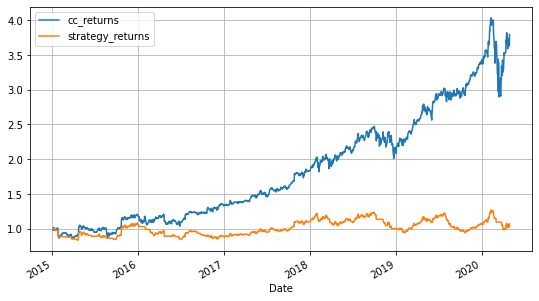

In [79]:
df1b = data.copy()

df1b['cc_returns'] = df1b['Close'].pct_change()
ema = 30
df1b['ema'] = df1b['Close'].ewm(span=ema, adjust=False).mean()
# No Short Selling is allowed
df1b['position'] = np.where((df1b['Close'] > df1b['ema']), 1, 0)
df1b['position'] = df1b['position'].shift(1)

df1b['position'].value_counts()

df1b['strategy_returns'] = df1b['cc_returns'] * df1b['position']


df1b['strategy_returns'] = 1 + df1b['strategy_returns']
df1b['cc_returns'] = 1 + df1b['cc_returns']



df1b[['cc_returns', 'strategy_returns']].cumprod().plot(grid=True, figsize=(9, 5))

print('Buy and hold returns: ', np.round(df1b['cc_returns'].cumprod()[-1], 2))
print('Strategy Long Only returns: ', np.round(df1b['strategy_returns'].cumprod()[-1], 2))